# Systematic Clustering Analysis upon Binary Multimorbidity Data

This notebook demonstrates how to use the functions from the `clustr` package to do a systematic clustering analysis.

Please read the directions in the `README.md` before proceeding.

In this notebook, I use the `dummy_file.tsv`. While it is in the proper format, it is randomly generated and has no information about real conditions or participants. Consequently, the clustering results are meaningless. Most datasets containing patient information require special permission to distribute, so this notebook is dedicated exclusively to functionality.

In [1]:
import pandas as pd
import os
import os.path as osp
import statistics
import json

# Load in the results folders, designated in constants:
from clustr.constants import HIER_AGG_RESULTS, KMEDOIDS_RESULTS, KMODES_RESULTS, LCA_RESULTS

from clustr.utils import get_data, plot_ks, dict_to_json
from clustr.hier_agg_utils import get_agg_clusters, plot_dendrogram
from clustr.kmedoids_utils import calculate_kmedoids, fit_kmedoids
from clustr.kmodes_utils import calculate_kmodes, fit_kmodes
from clustr.lca_utils import select_lca_model, get_lca_clusters

## Data:

Instructions on data formatting as well as the how-to to create the dummy file are also in the `README.md`. 

### Dummy file:

Let's take a look at what the dummy file looks like:

In [2]:
mmorb_df = pd.read_csv('./data/dummy_data.tsv', sep='\t', index_col=0)

In [3]:
mmorb_df.head(5)

,disease_1,disease_2,disease_3,disease_4,disease_5,disease_6,disease_7,disease_8,disease_9,disease_10,...,disease_41,disease_42,disease_43,disease_44,disease_45,disease_46,disease_47,disease_48,disease_49,disease_50
index,,,,,,,,,,,,,,,,,,,,,
1,1,0,0,1,1,1,1,1,0,0,...,0,0,0,0,1,0,0,1,0,1
2,0,1,0,0,1,0,1,0,1,0,...,1,0,1,0,0,1,0,1,0,1
3,1,1,1,0,1,1,1,0,1,1,...,0,1,1,1,1,1,1,0,0,0
4,1,1,1,0,1,0,1,0,0,0,...,0,0,1,0,0,0,1,0,0,1
5,0,0,0,0,1,0,0,0,0,1,...,0,0,1,0,1,0,1,1,1,1


### Data Preparation

Let's use the `get_data` function to prepare a sample of 10% of the data. Remember that reading all the data might be memory intensive, so think about whether your machine can do so.

In [4]:
processed_df, input_matrix, patient_ids, excluded_col, conditions = get_data('./data/dummy_data.tsv',
                                                                             sample_frac=0.01,
                                                                             drop_healthy=True,
                                                                             coi='disease_3')

In [5]:
processed_df.head(5)

,disease_1,disease_2,disease_4,disease_5,disease_6,disease_7,disease_8,disease_9,disease_10,disease_11,...,disease_42,disease_43,disease_44,disease_45,disease_46,disease_47,disease_48,disease_49,disease_50,tot_conditions
index,,,,,,,,,,,,,,,,,,,,,
9954,1,0,0,1,0,0,1,1,1,0,...,1,0,1,1,0,1,1,1,0,31
3851,0,1,0,0,0,1,1,0,0,1,...,1,0,0,0,1,1,1,1,0,23
4963,0,0,1,1,1,0,0,1,1,1,...,1,0,1,1,0,0,0,1,0,25
3887,1,1,1,1,1,0,0,0,1,0,...,0,0,0,0,1,0,1,0,1,27
5438,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,1,1,18


Note that we held out disease_3. Perhaps that's because we want to use those later and not in the clustering. Therefore, those features are saved alongside the patient IDs within another object:

In [6]:
excluded_col.head(5)

index
9954    1
3851    1
4963    1
3887    0
5438    1
Name: disease_3, dtype: int64

We also have objects saving patient IDs and disease names:

In [7]:
patient_ids[0:10]

[9954, 3851, 4963, 3887, 5438, 8518, 2042, 1990, 1934, 9985]

In [8]:
conditions[0:10]

['disease_1',
 'disease_2',
 'disease_4',
 'disease_5',
 'disease_6',
 'disease_7',
 'disease_8',
 'disease_9',
 'disease_10',
 'disease_11']

Finally, we have the matrix which we can feed into the clustering methods:

In [9]:
input_matrix

array([[1, 0, 0, ..., 1, 1, 0],
       [0, 1, 0, ..., 1, 1, 0],
       [0, 0, 1, ..., 0, 1, 0],
       ...,
       [1, 1, 0, ..., 1, 0, 0],
       [1, 0, 1, ..., 0, 1, 0],
       [0, 0, 1, ..., 1, 1, 1]])

## Clustering

I'll make the recommended results folders for each clustering approach. You can also make your own directories and write the results wherever you want.

In [10]:
for dir in [HIER_AGG_RESULTS, KMEDOIDS_RESULTS, KMODES_RESULTS, LCA_RESULTS]:
    os.makedirs(dir, exist_ok=True)

### Agglomerative Hierarchical Clustering (AHC)

Remember that AHC works consistently, so we should get the same results each time.

We can, however, change the linkage type or metric. The default is complete linkage with Hamming distance. We use the [sklearn function](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html), so other options can be explored there.

We save the model and the labels.

In [11]:
model, labels = get_agg_clusters(data_mat=input_matrix,
                                 out_folder=HIER_AGG_RESULTS)

The labels record which clusters the participants, or patients, belong to. The order corresponds to the `patient_ids` array from earlier.

In [12]:
labels[0:10]

array([9, 3, 0, 2, 7, 1, 1, 2, 0, 2])

In [13]:
print(f"The AHC approach identified {len(set(labels))} clusters.")

The AHC approach identified 10 clusters.


In [14]:
# Save a dataframe consisting of the patient IDs and their respective cluster assignments:
results_df = pd.DataFrame({'patient_id': patient_ids, 'cluster': labels})
# Output to the HIER_AGG_RESULTS directory:
results_df.to_csv(osp.join(HIER_AGG_RESULTS, 'hier_agg_labels.tsv'), sep='\t', index=False)

Notice that you also have a `scores.json` file within your results directory. This contains the final clustering metrics including the silhouette score, Calinski and Harabasz score, and Davies Bouldin score.

If you want to visualize the dendrogram, you can do so. This is particularly useful for choosing the best linkage type and metric.

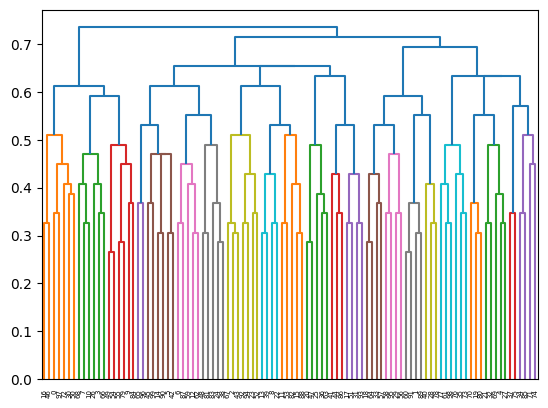

In [15]:
plot_dendrogram(data_mat=input_matrix,
                out_folder=HIER_AGG_RESULTS)

Since the data we generated is random, it should be unsurprising that the clusters look like this!

### *K*-medoids clustering

Let's do *K*-medoids clustering next, since it is also consistent. We implement it with [sklearn's function](https://scikit-learn-extra.readthedocs.io/en/stable/generated/sklearn_extra.cluster.KMedoids.html) with cosine similarity.

First, unlike AHC, we have to choose the number of clusters, *k*. We can plot silhouette scores for each model corresponding to a different *k*.

First, run for some range of *k*. We'll do [2, 10].

In [16]:
costs, sil_scores = calculate_kmedoids(data_mat=input_matrix,
                                      min_k=2,
                                      max_k=10)

We can save those costs and silhouette scores (maybe we want to use them later?):

In [17]:
dict_to_json(sil_scores, osp.join(KMEDOIDS_RESULTS, 'sil_scores.json'))
dict_to_json(costs, osp.join(KMEDOIDS_RESULTS, 'costs.json'))

Plot a scree plot of the costs of each model against *k*:

In [18]:
plot_ks(cost=costs,
        out_folder=KMEDOIDS_RESULTS,
        min_k=2,
        max_k=10)

You can also plot the silhouette scores, instead, if you want:

In [19]:
plot_ks(cost=sil_scores,
        out_folder=KMEDOIDS_RESULTS,
        metric='silhouette',
        min_k=2,
        max_k=10)

Typically, you want to use the [elbow method](https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/) on the costs scree plot, but since this is fake data, it doesn't really work. Let's just choose *k*=7 and fit the final model.

Here, we also have centroids, so we pass the `conditions` array as an argument so that it can tell us what conditions the centroids comprise.

In [20]:
model, labels = fit_kmedoids(data_mat=input_matrix,
                             out_folder=KMEDOIDS_RESULTS,
                             cgrps=conditions,
                             k=7)

Again, labels record which clusters the participants, or patients, belong to. The order corresponds to the `patient_ids` array from earlier.

In [21]:
print(f"The k-medoids approach identified {len(set(labels))} clusters.")

The k-medoids approach identified 7 clusters.


In [22]:
# Save a dataframe consisting of the patient IDs and their respective cluster assignments:
results_df = pd.DataFrame({'patient_id': patient_ids, 'cluster': labels})
# Output to the HIER_AGG_RESULTS directory:
results_df.to_csv(osp.join(KMEDOIDS_RESULTS, 'kmedoids_cluster_labels.tsv'), sep='\t', index=False)

Also, again, notice that you also have a `scores.json` file within your results directory. This contains the final clustering metrics including the silhouette score, Calinski and Harabasz score, and Davies Bouldin score.

### *K*-modes Clustering

Now we move on to those that are less consistent. Since it's sensitive to the intial cluster assignments, *k*-modes is better to be done in replicates, and this notebook will show you how.

We implement *k*-modes with the [kmodes module](https://pypi.org/project/kmodes/) and the Huang metric.

First, as before, we need to select the most appropriate *k*.

In [23]:
costs, sil_scores = calculate_kmodes(data_mat=input_matrix,
                                     min_k=2,
                                     max_k=10)

We can save those costs and silhouette scores (maybe we want to use them later?):

In [24]:
dict_to_json(sil_scores, osp.join(KMODES_RESULTS, 'sil_scores.json'))
dict_to_json(costs, osp.join(KMODES_RESULTS, 'costs.json'))

Plot a scree plot of the costs of each model against *k*:

In [25]:
plot_ks(cost=costs,
        out_folder=KMODES_RESULTS,
        min_k=2,
        max_k=10)

You can also plot the silhouette scores, instead, if you want:

In [26]:
plot_ks(cost=sil_scores,
        out_folder=KMODES_RESULTS,
        metric='silhouette',
        min_k=2,
        max_k=10)

Again, you want to use the [elbow method](https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/) on the costs scree plot, but since this is fake data, it doesn't really work. Let's just choose *k*=7 again and fit the final model.

Here, we also have centroids, so we pass the `conditions` array as an argument so that it can tell us what conditions the centroids comprise.

In [27]:
model, labels = fit_kmedoids(data_mat=input_matrix,
                             out_folder=KMODES_RESULTS,
                             cgrps=conditions,
                             k=7)

Again, labels record which clusters the participants, or patients, belong to. The order corresponds to the `patient_ids` array from earlier.

In [28]:
print(f"The k-modes approach identified {len(set(labels))} clusters.")

The k-modes approach identified 7 clusters.


In [29]:
# Save a dataframe consisting of the patient IDs and their respective cluster assignments:
results_df = pd.DataFrame({'patient_id': patient_ids, 'cluster': labels})
# Output to the HIER_AGG_RESULTS directory:
results_df.to_csv(osp.join(KMODES_RESULTS, 'kmodes_cluster_labels.tsv'), sep='\t', index=False)

Also, again, notice that you also have a `scores.json` file within your results directory. This contains the final clustering metrics including the silhouette score, Calinski and Harabasz score, and Davies Bouldin score.

#### Repetitions

But what if we want to do some repetitions? We could do so by making subdirectories, then writing the results within each of those subdirectories!

In [30]:
# do 3 repetitions
repetitions = 3

In [31]:
for i in range(repetitions):
    subfolder = osp.join(KMODES_RESULTS, f'run_{i}')
    os.makedirs(subfolder, exist_ok=True)
    # run k-modes, and replace the out_folder argument with the subdirectory
    model, labels = fit_kmedoids(data_mat=input_matrix,
                             out_folder=subfolder,
                             cgrps=conditions,
                             k=7)
    # save the labels, and replace the out_folder argument with the subdirectory
    results_df = pd.DataFrame({'patient_id': patient_ids, 'cluster': labels})
    results_df.to_csv(osp.join(subfolder, 'kmodes_cluster_labels.tsv'), sep='\t', index=False)

Now, you see that there is a `scores.json` file for each run.

From those, you can calculate summary statistics. For example:

In [32]:
def summarize_runs(folder, num_runs):
    """Gets summary statistics for the given folder for runs 0-num_runs"""
    scores_dict = {'silhouette': [],
                  'davies_boulden': [],
                  'calinski_harabasz': []}

    best_runs = {'silhouette': None,
                  'davies_boulden': None,
                  'calinski_harabasz': None}

    for i in range(num_runs):
        scores_file = osp.join(folder, f'run_{i}/scores.json')
        with open(scores_file, 'r') as json_file:
            scores = json.load(json_file)
        for key, val in scores.items():
            scores_dict[key].append(val)
            if not best_runs[key]:
                best_runs[key] = (i, val)
            elif key == 'davies_boulden' and val < best_runs[key][1]:  # davies bouldin is minimized
                best_runs[key] = (i, val)
            elif key != 'davies_boulden' and val > best_runs[key][1]:  # the other two are maximized
                best_runs[key] = (i, val)

    avgs = dict()
    # stdevs = dict()
    for key, val in scores_dict.items():
        avgs[key] = f'({statistics.mean(val)}, {statistics.stdev(val)})'
        
    return avgs, best_runs

The above gets two dictionaries. The first contains tuples of (average, standard deviation), and the second dictionary comrprises tuples of (best run number, corresponding value).

We can try it:

In [33]:
summarize_runs(KMODES_RESULTS, 3)

({'silhouette': '(0.0006788596306004775, 0.0)',
  'davies_boulden': '(3.994101551044897, 0.0)',
  'calinski_harabasz': '(1.9239901795421404, 0.0)'},
 {'silhouette': (0, 0.0006788596306004775),
  'davies_boulden': (0, 3.994101551044897),
  'calinski_harabasz': (0, 1.9239901795421404)})

## Latent Class Analysis (LCA)

Finally, we can do Latent Class Analysis. We implemented it with code from [this repository](https://github.com/dasirra/latent-class-analysis/blob/master/src/test_lca.ipynb).

Here, we want to pick the best *k* classes (the most likely number of latent classes). With LCA, we can do this with BIC score. Lower BIC is better, so in reality, you should explore a range of *k*s until you see a plateau.

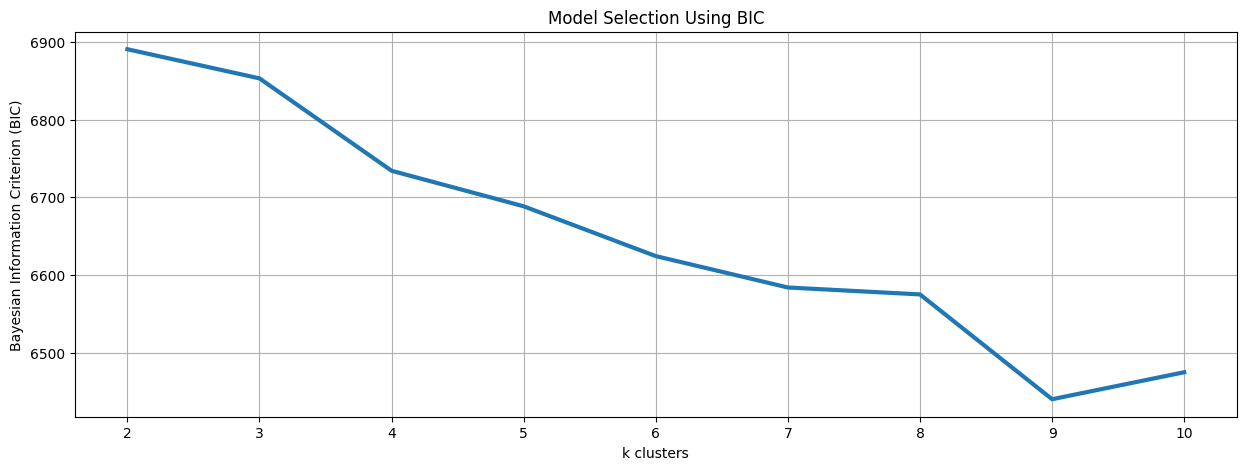

In [34]:
bics = select_lca_model(data_mat=input_matrix,
                        out_folder=LCA_RESULTS,
                        min_k=2,
                        max_k=10)

However, once again, since this is fake data, let's move on. We'll just choose *k*=10.

In [35]:
model, labels = get_lca_clusters(data_mat=input_matrix,
                                 out_folder=LCA_RESULTS,
                                 k=10)

Remember, though, that LCA is also sensitive to initialization, so let's do repetitions for it, just as we did for *k*-modes.

In [36]:
for i in range(repetitions):
    subfolder = osp.join(LCA_RESULTS, f'run_{i}')
    os.makedirs(subfolder, exist_ok=True)
    # run LCA, and replace the out_folder argument with the subdirectory
    model, labels = get_lca_clusters(data_mat=input_matrix,
                                 out_folder=subfolder,
                                 k=10)
    # save the labels, and replace the out_folder argument with the subdirectory
    results_df = pd.DataFrame({'patient_id': patient_ids, 'cluster': labels})
    results_df.to_csv(osp.join(subfolder, 'lca_cluster_labels.tsv'), sep='\t', index=False)

In [37]:
summarize_runs(LCA_RESULTS, 3)

({'silhouette': '(-0.040425590398753104, 0.03632767019259917)',
  'davies_boulden': '(2.8502993545712187, 0.2244254007014143)',
  'calinski_harabasz': '(2.0182913085371736, 0.14193527475264392)'},
 {'silhouette': (1, -0.0002332928940926245),
  'davies_boulden': (2, 2.6742797778173246),
  'calinski_harabasz': (1, 2.1462444069123343)})

And there we have it. Feel free to use this notebook as a starting point for exploring your data.